# Data Cleaning Notebook

## Objectives

* Assess and handle missing values 
* Clean data

## Inputs

* outputs/datasets/collection/HousePrices.csv

## Outputs

* Cleaned data in outputs/datasets/cleaned
* Data cleaning pipline

## Conclusions

* Drop ['EnclosedPorch', 'WoodDeckSF'] because each variable has more than 80% missing values.
* Nine out of 24 variables (75% of the columns) have missing values.


---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [ ]:
import os
current_dir = os.getcwd()
current_dir

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chdir() defines the new current directory

In [ ]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

Confirm the new current directory

In [ ]:
current_dir = os.getcwd()
current_dir

# Load Data

In [28]:
import pandas as pd
df = pd.read_csv("outputs/datasets/collection/HousePrices.csv")
df.head(5)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500
3,961,NaN,NaN,No,216,ALQ,540,NaN,642,Unf,...,60.0,0.0,35,5,7,756,NaN,1915,1970,140000
4,1145,NaN,4.0,Av,655,GLQ,490,0.0,836,RFn,...,84.0,350.0,84,5,8,1145,NaN,2000,2000,250000


# Data Exploration

In the quick display of the first five rows of our dataframe object above, we already see four columns and several cells with missing values. Here we dig deeper and get all variables that have missing values.

 * Nine out of 24 variables (which is 75% of the columns) have missing values. 

In [29]:
vars_with_missing_data = df.columns[df.isna().sum() > 0].to_list()
vars_with_missing_data

['2ndFlrSF',
 'BedroomAbvGr',
 'BsmtFinType1',
 'EnclosedPorch',
 'GarageFinish',
 'GarageYrBlt',
 'LotFrontage',
 'MasVnrArea',
 'WoodDeckSF']

In [30]:
df[vars_with_missing_data].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   2ndFlrSF       1374 non-null   float64
 1   BedroomAbvGr   1361 non-null   float64
 2   BsmtFinType1   1346 non-null   object 
 3   EnclosedPorch  136 non-null    float64
 4   GarageFinish   1298 non-null   object 
 5   GarageYrBlt    1379 non-null   float64
 6   LotFrontage    1201 non-null   float64
 7   MasVnrArea     1452 non-null   float64
 8   WoodDeckSF     155 non-null    float64
dtypes: float64(7), object(2)
memory usage: 102.8+ KB


### Profile Report

* We generate pandas profiling report for each variable with missing values.
  * We import pandas_profiling library and generate a profile report.
  * Some variable have many zeros.

In [31]:
# Code from walkthrough project 02, data cleaning notebook
from pandas_profiling import ProfileReport
if vars_with_missing_data:
    profile = ProfileReport(df=df[vars_with_missing_data], minimal=True)
    profile.to_notebook_iframe()
else:
    print("There are no variables with missing data")

/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/pandas/core/frame.py:4295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


Summarize dataset:   0%|          | 0/17 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

#### Assessing the distributions of numerical variables with missing values

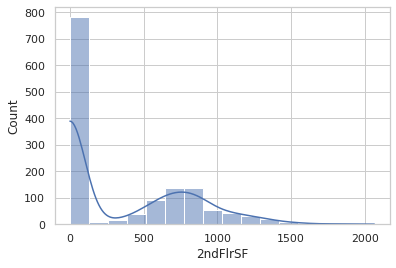

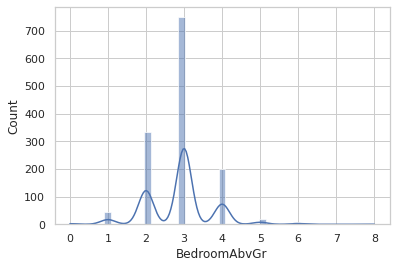

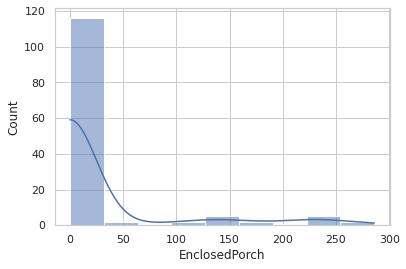

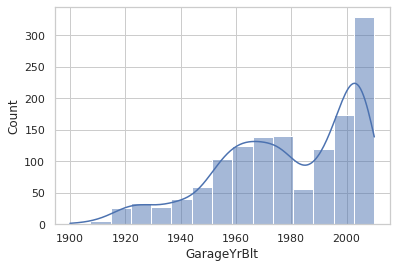

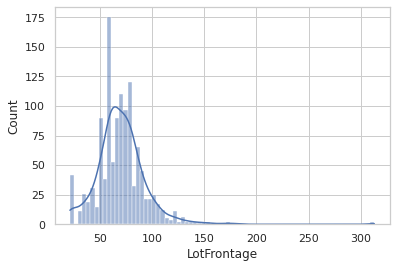

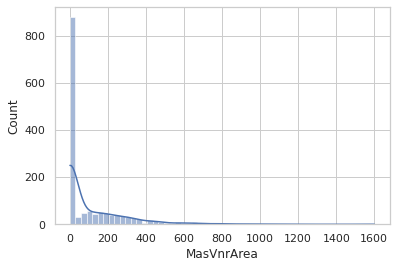

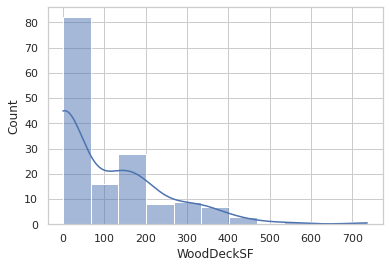

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
for col in vars_with_missing_data:
  if df[col].dtypes == 'float64':
    sns.histplot(data=df, x=col, kde=True)
    plt.show()

---

# Data Cleaning

## Assessing Missing Data Levels

* Custom function to display missing data levels in a dataframe, it shows the aboslute levels, relative levels and data type

In [33]:
def EvaluateMissingData(df):
  missing_data_absolute = df.isnull().sum()
  missing_data_percentage = round(missing_data_absolute/len(df)*100 , 2)
  df_missing_data = (pd.DataFrame(
                          data= {"RowsWithMissingData": missing_data_absolute,
                                 "PercentageOfDataset": missing_data_percentage,
                                 "DataType":df.dtypes}
                                  )
                    .sort_values(by=['PercentageOfDataset'],ascending=False)
                    .query("PercentageOfDataset > 0")
                    )

  return df_missing_data

Check missing data levels for collected dataset

In [34]:
EvaluateMissingData(df)

,RowsWithMissingData,PercentageOfDataset,DataType
EnclosedPorch,1324,90.68,float64
WoodDeckSF,1305,89.38,float64
LotFrontage,259,17.74,float64
GarageFinish,162,11.10,object
BsmtFinType1,114,7.81,object
BedroomAbvGr,99,6.78,float64
2ndFlrSF,86,5.89,float64
GarageYrBlt,81,5.55,float64
MasVnrArea,8,0.55,float64


## Handling Missing Data

* Defining DataCleaningEffect() function
  * Code copied and adapted from Unit 9 of the feature engine lesson

In [35]:
import seaborn as sns
sns.set(style="whitegrid")
import matplotlib.pyplot as plt

def DataCleaningEffect(df_original,df_cleaned,variables_applied_with_method):

  flag_count=1 # Indicate plot number
  
  # distinguish between numerical and categorical variables
  categorical_variables = df_original.select_dtypes(exclude=['number']).columns 

  # scan over variables, 
    # first on variables that you applied the method
    # if the variable is a numerical plot, a histogram if categorical plot a barplot
  for set_of_variables in [variables_applied_with_method]:
    print("\n=====================================================================================")
    print(f"* Distribution Effect Analysis After Data Cleaning Method in the following variables:")
    print(f"{set_of_variables} \n\n")
  

    for var in set_of_variables:
      if var in categorical_variables:  # it is categorical variable: barplot
        
        df1 = pd.DataFrame({"Type":"Original","Value":df_original[var]})
        df2 = pd.DataFrame({"Type":"Cleaned","Value":df_cleaned[var]})
        dfAux = pd.concat([df1, df2], axis=0)
        fig , axes = plt.subplots(figsize=(15, 5))
        sns.countplot(hue='Type', data=dfAux, x="Value",palette=['#432371',"#FAAE7B"])
        axes.set(title=f"Distribution Plot {flag_count}: {var}")
        plt.xticks(rotation=90)
        plt.legend() 

      else: # it is numerical variable: histogram

        fig , axes = plt.subplots(figsize=(10, 5))
        sns.histplot(data=df_original, x=var, color="#432371", label='Original', kde=True,element="step", ax=axes)
        sns.histplot(data=df_cleaned, x=var, color="#FAAE7B", label='Cleaned', kde=True,element="step", ax=axes)
        axes.set(title=f"Distribution Plot {flag_count}: {var}")
        plt.legend() 

      plt.show()
      flag_count+= 1

### Data Cleaning Summary
* Drop ['EnclosedPorch', 'WoodDeckSF'] because each has more than 80% missing values.
* Imputation
   * Mean- ['LotFrontage', 'BedroomAbvGr' ]
   * Median- ['2ndFlrSF', 'GarageYrBlt', 'MasVnrArea' ]
   * Categorical- ['GarageFinish','BsmtFinType1' ] 

In [36]:
from sklearn.pipeline import Pipeline
from feature_engine.imputation import MeanMedianImputer, MeanMedianImputer, CategoricalImputer
from feature_engine.selection import DropFeatures


* Distribution Effect Analysis After Data Cleaning Method in the following variables:
['LotFrontage', 'BedroomAbvGr'] 




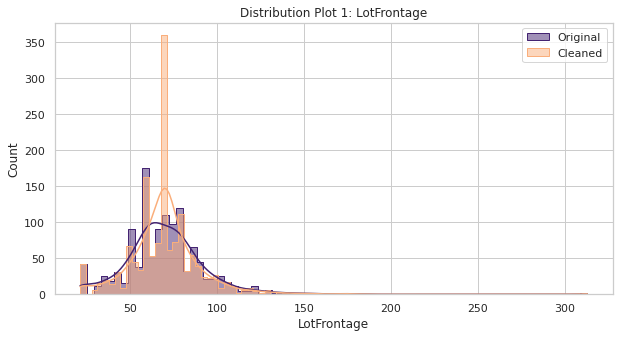

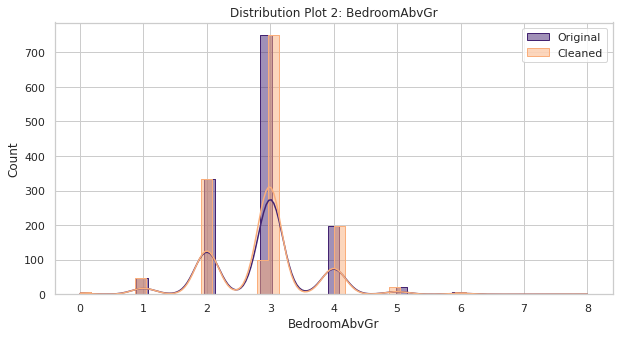

In [37]:
variables_mean = ['LotFrontage' , 'BedroomAbvGr']
imputer = MeanMedianImputer(imputation_method='mean', variables=variables_mean)
df_method = imputer.fit_transform(df)
DataCleaningEffect(df_original=df,
                   df_cleaned=df_method,
                   variables_applied_with_method=variables_mean)


* Distribution Effect Analysis After Data Cleaning Method in the following variables:
['2ndFlrSF', 'GarageYrBlt', 'MasVnrArea'] 




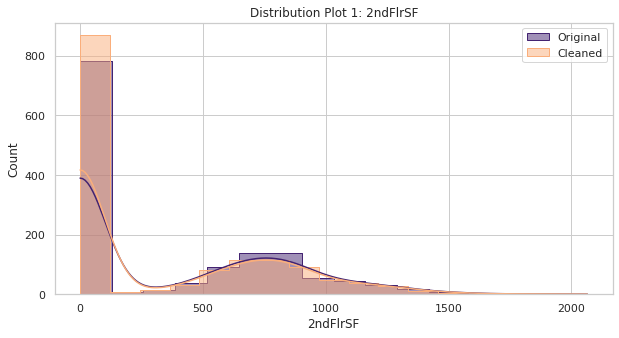

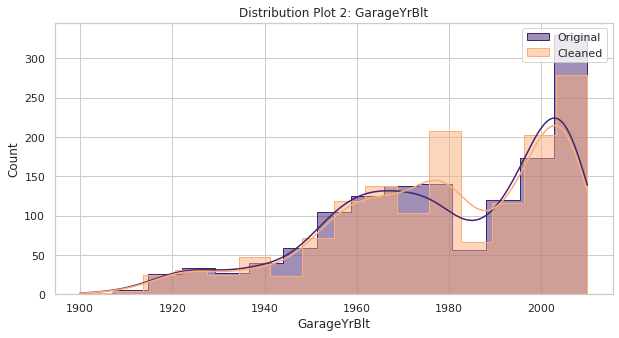

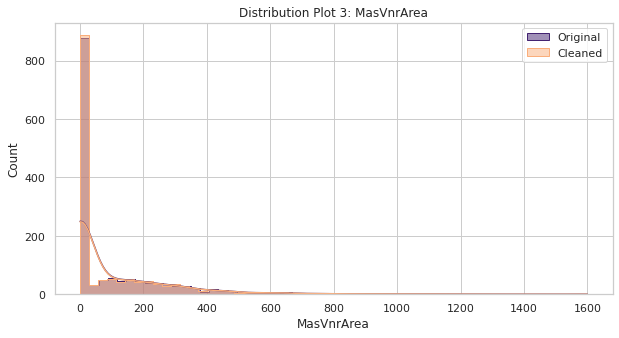

In [38]:
variables_median = ['2ndFlrSF' , 'GarageYrBlt', 'MasVnrArea']
imputer = MeanMedianImputer(imputation_method='median', variables=variables_median)
df_method = imputer.fit_transform(df)
DataCleaningEffect(df_original=df,
                   df_cleaned=df_method,
                   variables_applied_with_method=variables_median)


* Distribution Effect Analysis After Data Cleaning Method in the following variables:
['GarageFinish', 'BsmtFinType1'] 




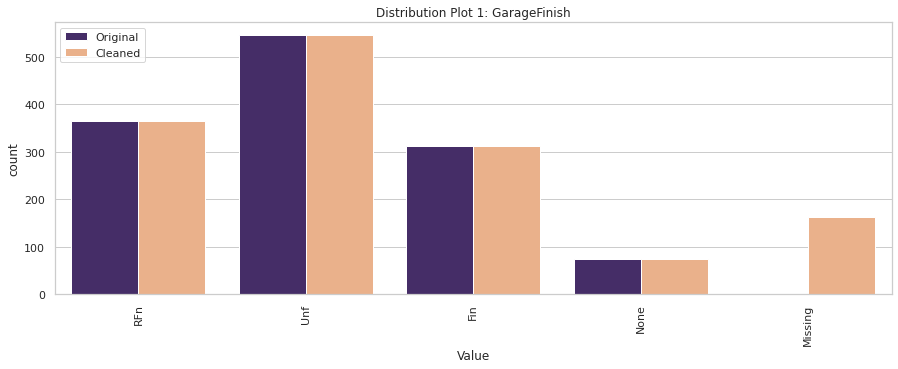

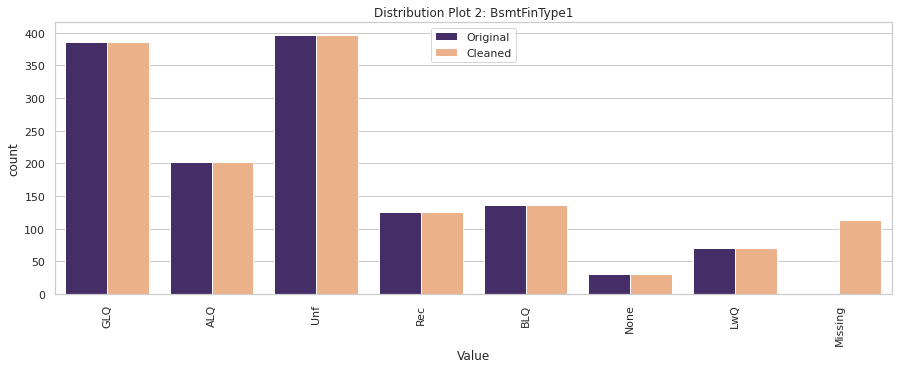

In [39]:
variables_categorical = ['GarageFinish' , 'BsmtFinType1']
imputer = CategoricalImputer(imputation_method='missing', fill_value='Missing', variables=variables_categorical)
df_method = imputer.fit_transform(df)
DataCleaningEffect(df_original=df,
                   df_cleaned=df_method,
                   variables_applied_with_method=variables_categorical)

In [40]:
pipeline = Pipeline([
      ( 'mean',  MeanMedianImputer(imputation_method='mean',
                                     variables=['LotFrontage' , 'BedroomAbvGr']) ),
      ( 'median',  MeanMedianImputer(imputation_method='median',
                                     variables=['2ndFlrSF' , 'GarageYrBlt', 'MasVnrArea']) ),
      ( 'categorical',  CategoricalImputer(imputation_method='missing',
                                     fill_value='Missing',
                                     variables=['GarageFinish' , 'BsmtFinType1']) ),
      ( 'drop',  DropFeatures(features_to_drop=['EnclosedPorch' , 'WoodDeckSF']) )
])

In [41]:
df = pipeline.fit_transform(df)

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   1stFlrSF      1460 non-null   int64  
 1   2ndFlrSF      1460 non-null   float64
 2   BedroomAbvGr  1460 non-null   float64
 3   BsmtExposure  1460 non-null   object 
 4   BsmtFinSF1    1460 non-null   int64  
 5   BsmtFinType1  1460 non-null   object 
 6   BsmtUnfSF     1460 non-null   int64  
 7   GarageArea    1460 non-null   int64  
 8   GarageFinish  1460 non-null   object 
 9   GarageYrBlt   1460 non-null   float64
 10  GrLivArea     1460 non-null   int64  
 11  KitchenQual   1460 non-null   object 
 12  LotArea       1460 non-null   int64  
 13  LotFrontage   1460 non-null   float64
 14  MasVnrArea    1460 non-null   float64
 15  OpenPorchSF   1460 non-null   int64  
 16  OverallCond   1460 non-null   int64  
 17  OverallQual   1460 non-null   int64  
 18  TotalBsmtSF   1460 non-null 

In [43]:
profile = ProfileReport(df=df, minimal=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/30 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

---

## Push files to Repo

In [44]:
try:
  os.makedirs(name='outputs/datasets/cleaned')
except Exception as e:
  print(e)

[Errno 17] File exists: 'outputs/datasets/cleaned'


In [45]:
df.to_csv("outputs/datasets/cleaned/HousePricesCleaned.csv", index=False)

### Split Train and Test Set

In [47]:
from sklearn.model_selection import train_test_split
TrainSet, TestSet, _, __ = train_test_split(
                                        df,
                                        df['SalePrice'],
                                        test_size=0.2,
                                        random_state=0)

print(f"TrainSet shape: {TrainSet.shape} \nTestSet shape: {TestSet.shape}")

TrainSet shape: (1168, 22) 
TestSet shape: (292, 22)


### Train Set

In [48]:
TrainSet.to_csv("outputs/datasets/cleaned/TrainSetCleaned.csv", index=False)

### Test Set

In [49]:
TestSet.to_csv("outputs/datasets/cleaned/TestSetCleaned.csv", index=False)